
BUILDING & TRADING FX QUANTITATIVE MODELS WITH AI & SIGNAL FILTERING

0. INTRODUCING THE APPROACH

1. PREPARING THE DATABASE WITH CURRENCY INDEXES

2. FILTERING NOISE WITH A LOWPASS FILTER

3. PREPARING THE DEEP LEARNING MODEL (LSTM)

4. TRAINING THE NEURONS

5. VALIDATING THE TRADING SIGNALS

6. INCORPORING MONEY MANAGEMENT

7. BACKTESTING

8. INCORPORING RISK MANAGEMENT

9. PREPARING THE EXECUTION

10. RUNNING THE TRADING SYSTEM

11. MONITORING THE SYSTEM



0. INTRODUCING THE APPROACH

Foreign Exchange (FX) trading is one of the most competitive activities in the world because of its market efficiency (data randomnes) and high volatility. Besides other financial instruments, FX makes traditional portfolio managers title it as gambling because of its difficulty in price prediction. Most big firms use FX to cover their currency risk on the positions of international commodities, assets and other tradeables. Although its an excellent market for algorithmic trading - specially in the sell-side - for its 24-5 continuity, high transactional volume and excellent liquidity. Most trading systems fail after 2 to 4 years because of its approach based in linear models or traditional indicators in a chaotic universe. High Frequency Trading systems are beneficiated mostly by noise and not by information

Financial markets are continuetly evolving. I like to say that markets are the spectrogram of society. Differently than others, FX is completely a bidirectional game. 

In this paper I'd like to demostrate that FX can be predicated 

To simplify it, we have two approaches when it comes to trading, follow the trend or mean-reversion strategies. However, the trend concept 

FX it's very corrective, however when a strong trend starts caused by any macroeconomic factor you better surf the trend and not fight against it if you want to survive.

In this notebook I'll expalin my fundamental approach to FX quantitative trading. First we will simplify 45 pairs to 10 currency indices, which will allow us to observe the market desegmented and catch easier the trending pairs and the corrective ones.

Through this notebook I'll explain step by step each process and its logic. Hope you enjoy it.

1. PREPARING THE DATABASE WITH CURRENCY INDEXES

In order to don't charge to much our pc's RAM we'll create a local database (db) of all the symbols to be analyzed and traded. Each instrument will have it's own csv file and its timeframe folder. It will help later to backtest our model as well.

In [61]:
# 1. PREPARING THE DATABASE WITH CURRENCY INDEXES

# import libraries for the module
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from datetime import timedelta, date, datetime
from pathlib import Path
from numpy import isnan
import pandas as pd
pd.options.plotting.backend = "plotly"

# Year to start
YEAR = 2020

# Oanda Authentificatiom
token = "37d11dc6e01ec900277bcf70ed296912-60827d532c22d5b1b0d3583a0e9309ef" # YOUR OANDA TOKEN
client = API(access_token=token)

# Instruments universe
symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD']  # 45 FX pairs


def importdb(year, symbols, make_indexes):

    # extract currencies (ccys)
    ccys = []
    if make_indexes:
        for sym in symbols:
            p = sym.split('_')
            if len(p[0]) == 3 and p[0] not in ccys:
                ccys.append(p[0])
            if len(p[1]) == 3 and p[1] not in ccys:
                ccys.append(p[1])
            ccys.sort()

    # prepare dataframe
    def prepdf(year):

        def daterange(date1, date2):
            for n in range(int((date2 - date1).days)+1):
                yield date1 + timedelta(n)

        start_dt = date(year, 1, 1)
        end_dt = date(year, 12, 31)

        dates = []
        weekdays = [5, 6]
        for dt in daterange(start_dt, end_dt):
            if dt.weekday() not in weekdays:
                dates.append(dt.strftime("%Y-%m-%d"))
        symbols.sort()

        return pd.DataFrame(index=dates, columns=symbols)

    # loop years
    more = True
    while more:

        prices = prepdf(year)
        changs = prepdf(year)
        volats = prepdf(year)

        _from = str(year)+'-01-01'
        _to = str(year)+'-12-31'
        # if it's current year
        if year == datetime.today().year:
            _to = str(datetime.today())[0:10]
            prices = prices.truncate(after=_to)
            changs = changs.truncate(after=_to)
            volats = volats.truncate(after=_to)
            more = False

        params = {'granularity': 'D', 'from': _from, 'to': _to}

        # import from oanda
        for sym in symbols:
            r = instruments.InstrumentsCandles(sym, params)
            r = client.request(r)
            for p in r['candles']:
                dtime = datetime.strftime(datetime.strptime(
                    p['time'][0:10], '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
                price = round((float(p['mid']['o']) + float(p['mid']['h']) + float(
                    p['mid']['l']) + float(p['mid']['c'])) / 4, len(p['mid']['c'].split('.')[1]))
                chang = round(
                    (float(p['mid']['c']) / float(p['mid']['o']) - 1) * 100, 2)
                volat = round(
                    (float(p['mid']['h']) / float(p['mid']['l']) - 1) * 100, 2)
                prices[sym][dtime] = price
                changs[sym][dtime] = chang
                volats[sym][dtime] = volat

        # clean nans
        for sym in symbols:
            changs[sym] = changs[sym].fillna(0)
            volats[sym] = volats[sym].fillna(0)
            for i in range(len(prices.index)):
                if isnan(prices[sym][i]):
                    try:
                        prices[sym][i] = prices[sym][i-1]
                    except:
                        prices[sym][i] = prices[sym][i+1]

        # create instruments db
        path = 'bin/db/instruments/'+str(year)+'/'
        Path(path).mkdir(parents=True, exist_ok=True)
        prices.to_csv(path+'prices.csv', index=True)
        changs.to_csv(path+'changs.csv', index=True)
        volats.to_csv(path+'volats.csv', index=True)

        if make_indexes:
            # make currency indices (idx)
            idx_ch = pd.DataFrame(index=prices.index, columns=ccys)
            idx_vo = pd.DataFrame(index=prices.index, columns=ccys)

            for dt in idx_ch.index:
                for ccy in idx_ch.columns:
                    n = 0
                    idx_ch[ccy][dt] = 0
                    idx_vo[ccy][dt] = 0
                    for sym in symbols:
                        if sym[0:3] == ccy:
                            idx_ch[ccy][dt] += changs[sym][dt]
                            idx_vo[ccy][dt] += volats[sym][dt]
                            n += 1
                        elif sym[4:7] == ccy:
                            idx_ch[ccy][dt] -= changs[sym][dt]
                            idx_vo[ccy][dt] += volats[sym][dt]
                            n += 1
                    idx_ch[ccy][dt] = round(idx_ch[ccy][dt] / n, 2)
                    idx_vo[ccy][dt] = round(idx_vo[ccy][dt] / n, 2)

            # create indexes db
            path = 'bin/db/indexes/'+str(year)+'/'
            Path(path).mkdir(parents=True, exist_ok=True)
            idx_ch.to_csv(path+'changs.csv', index=True)
            idx_vo.to_csv(path+'volats.csv', index=True)

            # plotting ccy indexes returns
            plt = idx_ch.plot(x=idx_ch.index, y=idx_ch.columns, height=400, title='CURRENCY INDEXES RETURNS '+str(year))
            plt.show()

            # plotting ccy indexes cumulative returns
            cum_idxs = idx_ch.cumsum()
            plt = cum_idxs.plot(x=idx_ch.index, y=idx_ch.columns, height=600, title='CURRENCY INDEXES CUMULATIVE RETURNS '+str(year))
            plt.show()

            # plotting ccy indexes volatility
            plt = idx_vo.plot.bar(x=idx_vo.index, y=idx_vo.columns, height=400, title='CURRENCY INDEXES VOLATILITY '+str(year))
            plt.show()

        print(year, 'imported!')

        year += 1


importdb( YEAR, symbols, True)
print('\ndb history updated!')


# credits: Quantium Rock


2020 imported!


2021 imported!


2022 imported!

db history updated!


2. FILTERING NOISE WITH A LOWPASS FILTER



In [60]:
# 2. FILTERING NOISE WITH A LOWPASS FILTER

# import libraries for the model
import pandas as pd
import scipy.signal as signal

# history parameters
sta = 2005 # start year
end = 2022 # end year

# importing database: indexes (idxs) and symbols (syms)
idxs = pd.read_csv('bin/db/indexes/'+str(sta)+'/changs.csv', index_col=0)
syms = pd.read_csv('bin/db/instruments/'+str(sta)+'/changs.csv', index_col=0)
for i in range(1,end-sta):
    idx2 = pd.read_csv('bin/db/indexes/'+str(sta+i)+'/changs.csv', index_col=0)
    idxs  = pd.concat([idxs, idx2])
    sym2 = pd.read_csv('bin/db/instruments/'+str(sta+i)+'/changs.csv', index_col=0)
    syms  = pd.concat([syms, sym2])
   
# model windowing
ln = 10 # lookback periods (days)
wi = pd.DataFrame(index=idxs.index, columns=idxs.columns)
for ccy in idxs.columns:
    for i in range(ln, len(idxs.index)):
        array = []
        for j in range(ln):
            array.append(idxs.iloc[i-j][ccy])
        wi[ccy][idxs.index[i]] = array

wi = wi.dropna()

# lowpass filter
def lowpass( array ):
    # buterworth filter parameters
    N = 2  # filter order
    Wn = 0.3  # cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    # apply lowpass filter
    return round(signal.filtfilt(B, A, array).mean(), 2)

lp = pd.DataFrame(index=idxs.index, columns=wi.columns+'f')
lp = pd.merge(idxs, lp, left_index=True, right_index=True )
lp = lp.fillna(0)
for dt in lp.index:
    for ccy in lp.columns:
        lp[ccy+'f'][dt] = lowpass(wi[ccy][dt])

lp = lp.dropna()
print(lp.head())

# plotting ccy indexes cumulative returns
cum_lp = lp.cumsum()
plt = cum_lp.plot(x=cum_lp.index, y=cum_lp.columns, height=600, title='CURRENCY INDEXES CUMULATIVE RETURNS + LOWPASS FILTER')
plt.show()


KeyError: '2005-01-03'

We have created the FX G10 currency indices. Meaning that now we can observe each currency by separate. Let's plot it and see the correlation between them.

In [15]:
# A ROOKIE STRATEGY TO TEST THE MARKET

# lowpass filter
def LowPass( array ):
    # buterworth filter parameters
    N = 2  # filter order
    Wn = 0.3  # cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    # apply lowpass filter
    return signal.filtfilt(B, A, array)
    
# model windowing
ln = 10 # lookback periods (days)

for idx in idxs.columns:





In [16]:
# IMPROVING A SIGNAL WITH MONEY MANAGEMENT AND RISK MANAGAMENT

sigs = pd.DataFrame(index=idxs.index, columns=syms.columns)

for dt in idxs.index:
    for xs in idxs.columns:
        for ys in idxs.columns:
            if idxs[xs][dt] > idxs[ys][dt]:
                try: sigs[xs+'_'+ys][dt] = 1
                except: continue
            elif idxs[xs][dt] < idxs[ys][dt]:
                try: sigs[xs+'_'+ys][dt] = -1
                except: continue

sigs = sigs.shift(1).fillna(0)

perf = pd.DataFrame(index=syms.index, columns=['return'])

for dt in syms.index:
    ret = 0
    for sym in syms.columns:
        ret += syms[sym][dt] * sigs[sym][dt]
    perf['return'][dt] = ret

perf = perf.cumsum()
plt = perf.plot(x=perf.index, y='return')
plt.show() 

As we can oberseve some pairs that are currently very correlated, like USD/HKD or SGD/HKD or even EUR/JPY. It can be for multiple reasons, mainly caused by monetary policies. However, all this pairs are perfect for playing mean-reversion strategies. As both currencies are correlated the volatility of the pair will be low, that's why we call it beta pairs.

On the other hand, we have another class of pairs that are negatively correlated. These pairs will be more trendy, as their currencies are going on opposite directions. We'll look for signals to join the trend. We call it alpha pairs as are the most volatile ones.

Last we have the gamma pairs, which are uncorrelated (close to 0). The currencies compounding these pairs have a random relation apparently. Which are perfect for building an uncorrelated portfolio, we can look for trend or corrections.

In [199]:
beta = [] # pairs correlated above 0.75 -> which will be the corrective ones.
alpha = [] # pairs negative correlated below -0.75 -> which will be the tren ones.
gamma = [] # pairs uncorrelated between -0.25 and 0.25 -> which will be the ones we will use to uncorrelated our portfolio in the risk management section.

for base in currencies:
    for term in currencies:
        if base != term:
            if matrix[base][term] > 0.75:
                beta.append(base + '_' + term)
            elif matrix[base][term] < -0.75:
                alpha.append(base + '_' + term)
            elif matrix[base][term] > -0.2 and matrix[base][term] < 0.2:
                gamma.append(base + '_' + term)


beta = [ x for x in beta if x in symbols ]
alpha = [ x for x in alpha if x in symbols ]
gamma = [ x for x in gamma if x in symbols ]


print('\nbeta:', beta, '\nalpha:', alpha, '\ngamma:',gamma)


beta: ['USD_HKD'] 
alpha: ['AUD_HKD', 'AUD_USD', 'CAD_CHF', 'CHF_JPY'] 
gamma: ['AUD_CHF', 'AUD_JPY', 'AUD_SGD', 'CHF_HKD', 'EUR_CHF', 'GBP_CAD', 'GBP_CHF', 'GBP_NZD', 'GBP_SGD', 'HKD_JPY', 'SGD_HKD', 'USD_CHF', 'USD_SGD']


[-0.00116417 -0.00139094  0.00195951  0.00293134 -0.00437535 -0.00637313
  0.00902803  0.01248116 -0.0169409  -0.02273977  0.03045372  0.04118039
 -0.05729369 -0.08500841  0.14720004  0.45005217  0.45005217  0.14720004
 -0.08500841 -0.05729369  0.04118039  0.03045372 -0.02273977 -0.0169409
  0.01248116  0.00902803 -0.00637313 -0.00437535  0.00293134  0.00195951
 -0.00139094 -0.00116417]


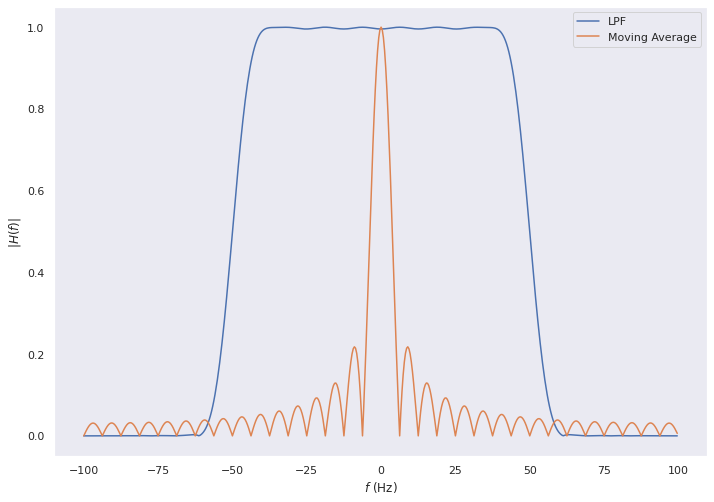

In [201]:
from pylab import *
from scipy.signal import firwin
from pylab import arange, ones


Fs = 200.

N = 32
h_lpf = firwin(N, 50, nyq=Fs/2., window='hamming')
h_ma = ones(N)*1./N

print(h_lpf)

M = 512


X_lpf = fftshift(abs(fft(h_lpf, M)))
X_lpf /= X_lpf.max()
X_ma = fftshift(abs(fft(h_ma, M)))
X_ma /= X_ma.max()

f = arange(M)*Fs/M - Fs/2.

figure()
plot(f, X_lpf, f, X_ma)
xlabel('$f$ (Hz)')
ylabel('$|H(f)|$')
legend(('LPF', 'Moving Average'))
grid()
show()

In [217]:
def low_pass_weights(series, window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = series
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


df = low_pass_weights(idx['AUD'][0:60],121, 1. / 24.) 

idx['AUD'][0:60]


date
2008-06-08T21:00:00    12.53
2008-06-09T21:00:00    12.72
2008-06-10T21:00:00    12.49
2008-06-11T21:00:00    11.80
2008-06-12T21:00:00    12.42
2008-06-15T21:00:00    12.29
2008-06-16T21:00:00    12.45
2008-06-17T21:00:00    12.63
2008-06-18T21:00:00    12.99
2008-06-19T21:00:00    12.97
2008-06-22T21:00:00    13.22
2008-06-23T21:00:00    13.33
2008-06-24T21:00:00    13.55
2008-06-25T21:00:00    12.94
2008-06-26T21:00:00    13.12
2008-06-29T21:00:00    12.98
2008-06-30T21:00:00    12.68
2008-07-01T21:00:00    13.06
2008-07-02T21:00:00    13.38
2008-07-03T21:00:00    13.67
2008-07-05T21:00:00    13.67
2008-07-06T21:00:00    13.20
2008-07-07T21:00:00    13.12
2008-07-08T21:00:00    13.04
2008-07-09T21:00:00    13.50
2008-07-10T21:00:00    13.51
2008-07-12T21:00:00    13.70
2008-07-13T21:00:00    13.78
2008-07-14T21:00:00    14.02
2008-07-15T21:00:00    13.83
2008-07-16T21:00:00    13.85
2008-07-17T21:00:00    13.84
2008-07-18T21:00:00    13.84
2008-07-19T21:00:00    13.97
2008-07-2

In [ ]:

import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')